# Encoding through space
_this article was first written in 2018_


### At the begining was information
As the various space agencies go deeper and farther into the unknown of our universe, it is very important for the probes to report to the earth scientists. However, sending data from so far in space is especially challengind because one has only a very constraind through-put at hand. This limitation originates mostly because of data corruption and the limited amount of energy that can be consumed by the probe.

It is therefore crutial to put a good compression system in place. We will look at introductory techniques that can be applied at the lowest lever, namely the encoding process. 

To put us into context, let's imagine that we stand in a spacecraft far in space. Here is the picture of our rover that we would like to send back to earth.

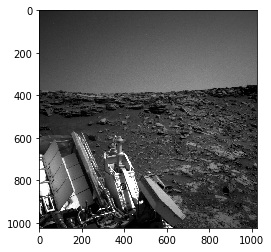

In [85]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

mars = np.array(imageio.imread("robot.JPG")) / 255
unique, counts = np.unique(mars, return_counts=True)

plt.imshow(mars, cmap="gray")
plt.show()

#### Discretization, quantization and encoding

If we assume that our analogous camera to yield infinite precision images, i.e. each pixel takes a value in the dense continuous range $[0, 1]$, we first face the digitalization problem. That is, to be able to use an encoding we first need to convert the continuous pixels into a discrete, or digitalized space. Digitalization can be thought of as two dinstinct processes that are intricate in practice: discretization and quantization. 


**Discretization** consists of splitting our continuous domain into a discrete set of measurements. This involves chosing a sampling rate which can already be a none-trivial task to lose as little information that we care about as possible. 

**Quantization** is the process to convert these now discretized so countable measurements from a continuous range into a discrete range. At this stage, we don't care of the representation of these values but rather on the precision. We can therefore say that after the quantization process, we are left with a countable set of measurements and the belong to the _source alphabet $\mathcal{A} = [N] = 0, 1, ..., N$_.

> Discretization and Quantization together can be considered as the steps required to convert a (pseudo-)continuous information source into a discrete information source.

**Encoding** is the design of an encoding function.
\begin{definition}
An encoding function $\Gamma: \mathcal{A} \rightarrow \mathcal{C}$ is a bijective mapping from words of the source alphabet $\mathcal{A}$ to symbols of a codebook $\mathcal{C}$.
\end{definition}
\begin{definition}
A codebook $\mathcal{C}$ consists of a finite set of finite length strings from a target alphabet $\mathcal{T}$, i.e.
$$
    \mathcal{C} \subseteq \mathcal{T}^N,\, N < \infty 
$$
\end{definition}

In most applications, we can take a binary target alphabet $\mathcal{T} = \{0, 1\}$. One of the challenge in encoding is to minimize the expected length of the encoded messages. We will look at specific assumptions later.

Let us set aside that we have to chose a sampling rate and get a finite number of measurements and assume that we get one of such "infinite" measurement per future pixel in the digitalized picture. We will also assume a rather simple quatization process, namely rounding, to focus on the encoding process. That is our quantization proposal would be to chose an arbitrary precision range $r$, e.g. $r = 0.1$ and split the range $[0, 1]$ into a nine bins of range $r$. 

> Note that some applications such as ours can benefit from more complex quantization process. For example, the human vision is more sensitive to shades of green than to shades of blue. It follows that having a higher precision in the greensthan in the blue region would produce a better looking digitalized picture with the same amount of information. There exists different color models, some of most popular are RedGreenBlue (RGB) or HueSaturationLightness (HSL). Different models would yield different visual properties for the same encoding scheme.

![historical color model](./farbenkugel.jpg "Logo Title Text 1")

After rounding the measurements, we then encode the each bin with a symbol from the codebook $T$. But how to chose these symbols and this codebook? Naively, let us just count them first but attributing the number 0 to the first bin, 1 to the second one, and so on. Of course those symbols must be described in binary format as we assume a binary target alphabet.

|bin number|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
|symbol|0|1|10|11|100|101|110|111|1000|

However, one practical problem arises: how to decode the following string $110$? It can either be decoded to (2, 3) or (4, 1) by splitting the string after the first or second character respectively. It is impossible to know so we need some additional convention (we'll see more clever ideas later on). We can state that this first encoding is _not uniquely decodable_.

### Fixed-length coding
The first naive solution to this problem is to decide on a fixed symbol length for our target alphabet, just as [ascii](https://en.wikipedia.org/wiki/ASCII) does for example. This is called fixed-length coding. Note that we assume that we know where the message starts.

We have 9 words to encode and there exists $2^n$ different binary strings of length $n$. So we need a length of at least $2^n \geq 9 \rightarrow n = 4$ to have a uniquely decodable encoding. Our word to symbol encoding becomes:

|bin number|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
|symbol|0000|0001|0010|0100|1000|1001|1010|1100|0011|0101|

So put this first idea in practice and see how many bits we need to encode our mars panorama picture.

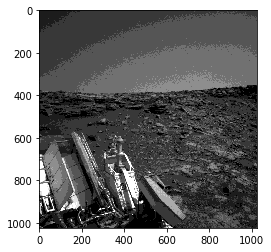

Encoded image is using 419.0 kbits


In [86]:
n_bins = 9
n = np.ceil(np.log2(n_bins))
mars_discretized = np.round(mars * n_bins - 1 / (2 * n_bins))
mars_discretized_bits = n * len(mars_discretized.flatten())

plt.imshow(mars_discretized, cmap="gray")
plt.show()

print(f"Encoded image is using {discretized_bits // 10e3} kbits")

## Huffman Coding
We can easily see that fixed-length has the adventage of being very simple and requires very little operations to encode or decode. In this section, we will follow some definition given by \cite{le2013sciences}. However, its expected average symbol length can be far from optimal and that this depends on the words distribution. If we consider each word as the realization of a random variable $\mathcal{X}: \Omega \rightarrow \mathcal{S}$, it is $P(\mathcal{X} = x),\, x\in \mathcal{S}$. It is important to say that for now we assume the realizations to be independent from each other. If the distribution $P$ is not uniform over $\mathcal{S}$, we can maybe achieve a better encoding by assigning shorter symbol length to words to occur more frequently. Having a **variable-length coding** strategy, we also need to enforce our encoding to be uniquely decodable.

\begin{definition}
An encoding function $\Gamma$ is uniquely decodable if and only if for any sequence of symbols from the codebook that was generated by encoding words from the source can be uniquely decoded.
\end{definition}

This could be reached by having a separator symbol for example but we will here focus on a another technique called **prefix-free coding**.

If we enforce that for any two symbols $t_1, t_2 \in \mathcal{T},\, t_1 \neq t_2$, $t_1$ cannot be a prefix of $t_2$, then we could easily differentiate between symbols without the need for a fixed length nor an arbitrary separator. This is prefix-free coding. Prefix free coding also implies (and is actually equivalent to) another interesting encoding property which is *instantaneity*.

\begin{definition}
An encoding function $\Gamma$ is *instantaneous* if and only if 
1. It is uniquely decodable
2. One can decode the symbols one-by-one in an online fashion. That is decoding each symbol as it comes and not caring about what comes next in the sequence.
\end{definition}

In the fifties, David Huffman came up with an especially smart way of building the alphabet depending on the distribution of the words in your corpus. Let us imagine you have the following word occurences:

|bin number|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
|occurences|91542|252384|265372|198916|121143|38165|22165|28564|30325|0101|

which looks as follows visually.

<BarContainer object of 10 artists>

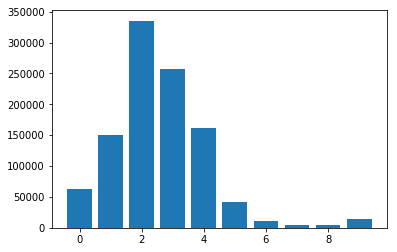

In [87]:
_, counts = np.unique(mars_discretized, return_counts=True)
plt.bar(range(len(counts)), counts)

Then, as mentioned before, it would make effective to have smaller bit-length symbols for *frequent* words and longer symbols for *unfrequent* words in order to diminish the average symbol length. Encoding schemes that take the source symbols distribution into account are called Entropy Coding and Huffman code is part of this family. To build the alphabet, we construct a binary tree recursively by combining the words with least occurences. This approach allows us to reduce the total size of the encoded image and is *lossless*, meaning that we did not lose information from the discretized image in the encoding process.

The Huffman's algorithm consists creating a coding tree on top of our distribution $P$ by always "merging" the two ends with the least probable realization. That is, from now on consider these to elements as one with the sum of their former probabilities an add a binary bit to the symbols distinguish between these two ends of the coding tree. Formally,

\begin{definition} Huffman's coding algorithm

**Input**: probability distribution $P$ and finite source alphabet $\mathcal{X}$.
1. q $\leftarrow$ empty priority queue
2. $\Gamma$ = {}
3. **for** x **in** $\mathcal{X}$:
  1. q.push(($P$(x), x))
  2. $\Gamma$[x] = empty string 
3. **while** q has more than one element:
  1. p_a, a $\leftarrow$ q.pop()
  2. p_b, b $\leftarrow$ q.pop()
  3. $\Gamma$[a].prepend('0')
  4. $\Gamma$[b].prepend('1')
  5. q.push((p_a + p_b, (a, b)))
4. return $\Gamma$
\end{definition}


For example, let us compute the Huffman code for the following toy distribution:

|$x$|a|b|c|d|
|---|---|---|---|---|
|$P(\mathcal{X} = x)$|0.125|0.5|0.125|0.25|

The two least probable symbols are a and c. Thus, let us merge their node and sum up the probabilies. We will assign the bit 0 to **a** and 1 to **c**. Graphically, we added a node (a, c) and branches from this node to a and c to the tree.

![huffman coding tree 1](./coding_tree_1.png)

and we recursively apply this procedure to the updated probability table:

|$x$|(a $\lor$ c)|b|d|
|---|---|---|---|
|$P(\mathcal{X} = x)$|0.25|0.5|0.25|

And in next step, the nodes (a, c) and d will be merged. In the end, the algorothm yields this final coding tree:

![huffman coding tree 3](./coding_tree_3.png)

and the string *abc* is encoded to 0001001.

By construction of the Huffman code tree, we can already identify that the coding will be **prefix-free**. Indeed, at each recursion step, we differentiate between two subtrees by making sure that they don't have the same first symbol. By induction, this holds then for all subtrees in the whole tree, including the leaves.
If we know that the coding is prefix-free, we also know from before that the code must be instantaneous and thus uniquely decodable.

Furthermore, Huffman code is also **the optimal instantaneous binary code for the given information source** (given that the frequencies are the true ones). In practice, the frequencies are often estimated and this leads to approximal optimality and we will see later that this can negatively impact the performance.

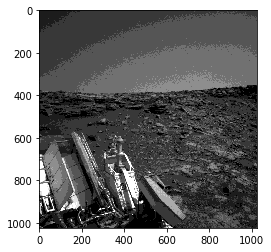

Encoded image is using 268.0 kbits
36.09% size reduction


In [88]:
from dataclasses import dataclass
import typing
from typing import List, Tuple, Optional, Dict


@dataclass()
class Node:
    count: int
    value: Optional[int]
    encoding: str = ""
    left_child: "Node" = None
    right_child: "Node" = None

    def __lt__(self, x):
        return self.count < x.count

    def is_leaf(self):
        return self.left_child is None and self.right_child is None

    def propagate_encoding(self, b: str) -> None:
        self.encoding = b + self.encoding
        if self.left_child:
            self.left_child.propagate_encoding(b)
        if self.right_child:
            self.right_child.propagate_encoding(b)

    def get_mapping(self) -> Dict:
        l = self.left_child.get_mapping() if self.left_child else {}
        r = self.right_child.get_mapping() if self.right_child else {}
        m = {self.value: self.encoding} if self.value is not None else {}
        m.update(l)
        m.update(r)
        return m


def huffman_coding(occurences: List[Node]) -> List[Node]:
    # base case
    if len(occurences) <= 1:
        return occurences

    mins = sorted(np.argsort(np.array(occurences), axis=0)[0:2])
    left = occurences[mins[0]]
    right = occurences[mins[1]]
    left.propagate_encoding("0")
    right.propagate_encoding("1")

    merged_node = Node(
        count=left.count + right.count,
        value=None,
        encoding="X",
        left_child=left,
        right_child=right,
    )

    updated_occs = (
        occurences[: mins[0]]
        + occurences[mins[0] + 1 : mins[1]]
        + occurences[mins[1] + 1 :]
        + [merged_node]
    )
    return huffman_coding(updated_occs)


def huffman_encode(image, encoding: Dict) -> str:
    return "".join(encoding[int(p)] for p in image.flatten())


def huffman_decode(encoded_string: str, encoding: Node) -> List[int]:
    decoded_string = []
    current_node = encoding
    for idx, c in enumerate(encoded_string + "."):
        if current_node.is_leaf():
            decoded_string += [current_node.value]
            current_node = encoding
        if c == "0":
            current_node = current_node.left_child
        elif c == "1":
            current_node = current_node.right_child
    return decoded_string


result = huffman_coding(list(Node(c, v) for c, v in zip(counts, range(len(counts)))))
encoding = result[0].get_mapping()

mars_encoded = huffman_encode(mars_discretized, encoding)
mars_decoded = np.array(huffman_decode(mars_encoded, result[0]))
mars_decoded = np.reshape(mars_decoded, mars_discretized.shape)
huffman_bits = len(mars_encoded)
plt.imshow(mars_decoded, cmap="gray")
plt.show()

print(f"Encoded image is using {huffman_bits // 10e3} kbits")
print(f"{(1 - huffman_bits / mars_discretized_bits) * 100:.2f}% size reduction")

So just by using a different encoding scheme, we could bring down the size of the picture about 45 percents! And again without losing any information at all! Of course, we used the data from a single image but we could also consider any number of images by gathering the overall count of each pixel value.
There is however something very important to realize: we suffer from the generalization problem.

### A generalization problem
In the Huffman coding, we used an image to build an encoding function which can optimally encode the image. However, we cannot know how well this would compress an image that will be taken in the future. If we assume that the images on which the coding was computed to have an underlying distribution and if we can expect new images to be close to this distribution, then new images will be well approximated in practice by our huffman code. But this is not necessarily the case. As a concrete example, we can take a corpus of books to encode consisting of all French modern novels before 2020. Then, very probably, our encoding function would do a great job encoding a new French novel from 2020. However, this is very probably not true for French peotry from the Middle Age which has a very different word distribution.


In our little story, it is not clear how new extra-terrestrial life forms would look like. Therefore, if we want to compute our encoding function before leaving earth, we might chose a corpus whose distribution does not represent well the new life form we might find.


To practically confirm this hypothesis, let's see how this encoding scheme computed on the rover picture would generalize to another martian image

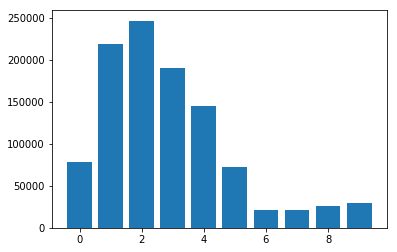

3192065
23.90% size reduction


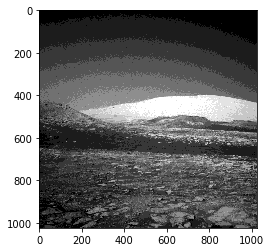

In [89]:
robot = np.array(imageio.imread("mars.JPG")) / 255
robot_discretized = np.round(robot * n_bins - 1 / (2 * n_bins))
robot_discretized_bits = n * len(mars_discretized.flatten())

_, counts = np.unique(robot_discretized, return_counts=True)
plt.bar(range(len(counts)), counts)
plt.show()

robot_encoded = huffman_encode(robot_discretized, encoding)
robot_decoded = np.array(huffman_decode(robot_encoded, result[0]))

robot_decoded = np.reshape(robot_decoded, robot_discretized.shape)
plt.imshow(robot_decoded, cmap="gray")

print(f"{len(robot_encoded)}")
print(f"{(1 - len(robot_encoded) / robot_discretized_bits) * 100:.2f}% size reduction")

So indeed, the encoding function which reduced the size the rover picture by half did not generalize well to our martial panorama and compressed it only of 20%. And it is clear that the pixel distributions of the two images differ: the last one is much brighter than the first one. Therefore, there's still room to improve our encoding strategy.

### Sending the encoding
One might argue that the solution to the generalization problem is simply to compute the encoding remotly and to send the custom tailored encoding along with the encoded picture. This can be seen as dynamically computing the encoding function as our data source changes. Let see what overhead it would entails in our case. Sending the encoding function requires at least $|\mathcal{S}|log|\mathcal{S}|$ bits and a picture is $d^2$. So in our toy example, it is clear that sending the encoding could be a viable option. But if $S >> d$ then it is not anymore. And if you want the standard 8 bits RGB precision, $|S| = 256^3 = 2^{24} \approx 10^7$ which is in the same order and the number of pixel in an image and it is already quite clear that you would not benefit from such strategy. 

By actually, this is an optimization problem which optimal solution is not always easy to compute. Indeed, we can also imagine not computing an encoding for the whole image(s) but rather by line or by square, or by any region corresponding to structural redundency. But this usually requires expert knowledge on the distribution of the images pixel and it relies on inter-pixel dependecy -- which we will investiguate in a further post. Don't forget that the Huffman coding solution that we described here consider the images as unordered set of pixel values and hence cannot use this inter-pixel dependence. \cite{verdu1998fifty}

#### NASA send me your code
In practice, NASA used in some of their previous mission huffman codes to encode each line of an image. They would then send the line encodings alongside with the image data back to earth. They combined this with a source alphabet reduction technique. To take advantage of the interpixel redudancy, each line was represented by a fixed offset for the first pixel and the following pixels by their respective difference to the left neighboring pixel. This gives a practical approximation of the left gradient of the image. For natural images which tend to have continuous pixel-values, this help to decrease the size of the source alphabet and to concentrate the probability distribution around 0. 

We can illustrate this using the last shown picture. If we apply the described lossless preencoding transformation, we get the following result

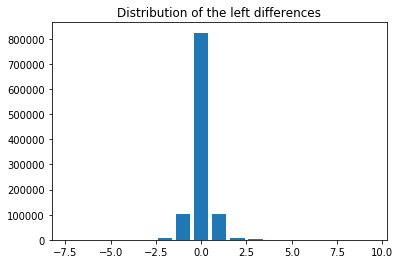

Encoded robot image is using 144.0 kbits
65.51% size reduction
Encoded mars image is using 152.0 kbits
63.58% size reduction


In [90]:
from functools import reduce
from time import time

# Thanksfully, our friend numpy implements it *fast*
mars_diff = np.diff(mars_discretized, n=1, prepend=0, axis=0)
# we add each possible alphabet value once to avoid some symbols to be missing
values, counts = np.unique(mars_diff, return_counts=True)
result = huffman_coding(list(Node(c, v) for c, v in zip(counts, values)))
encoding = result[0].get_mapping()

robot_diff = np.diff(robot_discretized, n=1, prepend=0, axis=0)

# plot the counts distribution
plt.bar(values, counts)
plt.title("Distribution of the left differences")
plt.show()

# compute the size of the encoded pre-processes image
mars_encoded = huffman_encode(mars_diff, encoding)
print(f"Encoded robot image is using {len(mars_encoded) // 10e3} kbits")
print(f"{(1 - len(mars_encoded) / discretized_bits) * 100:.2f}% size reduction")

robot_encoded = huffman_encode(robot_diff, encoding)
print(f"Encoded mars image is using {len(robot_encoded) // 10e3} kbits")
print(f"{(1 - len(robot_encoded) / discretized_bits) * 100:.2f}% size reduction")

# decoding sanity check
robot_diff_decoded = np.array(huffman_decode(robot_encoded, result[0]))
robot_diff_decoded = np.reshape(robot_diff_decoded, robot_discretized.shape)

robot_decoded = robot_diff_decoded.cumsum(axis=0)
assert (robot_decoded == robot_discretized).all()

And this solved our previous generalization issue! Now this will not work in all cases as this assumes some knowledge abou the data distribution. But on smooth natural images, this would help a lot in pratice by assigning small code length to small variations and longer codes to large variations.

## Arithmetic Coding

TBD

# References

(<a id="cit-le2013sciences" href="#call-le2013sciences">Le Boudec, Thiran <em>et al.</em>, 2013</a>) Le Boudec JEAN-YVES, Thiran PATRICK and Urbanke R{\"U}DIGER, ``_Sciences de l'information_'', , vol. , number , pp. ,  2013.

(<a id="cit-verdu1998fifty" href="#call-verdu1998fifty">Verdu, 1998</a>) Verdu Sergio, ``_Fifty years of Shannon theory_'', IEEE Transactions on information theory, vol. 44, number 6, pp. 2057--2078,  1998.

